<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---


* Guiddir Laurent

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://codalab.lisn.upsaclay.fr/competitions/12130

* **Étape 1 :** S'enregistrer sur https://codalab.lisn.upsaclay.fr

* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://codalab.lisn.upsaclay.fr/competitions/12130#participate-get_starting_kit) "Participate > Files > Public Data".

* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [5]:
import platform
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    neighbors,
    pipeline,
    preprocessing,
    svm,
    tree,
    neural_network
)

In [6]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

1.5.3
1.2.2


## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

Il s'agit d'une tâche de classification binaire entre $2$ classes : les patients qui vont mourir et ceux qui vont survivre.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

Les données ne sont pas bien équilibrées, donc il faut utiliser `balanced_accuracy_score` pour que les données veuillent dire quelque chose.

## 2. Chargement des données

In [7]:
#DATA = Path("/public_dat/")

DATA = Path("public_dat")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [8]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_raw_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

x_df = x_raw_df.copy()

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [9]:
print(x_df.shape)
x_df.head(3)

(79999, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [10]:
# Load test set
x_raw_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

x_test_df = x_raw_test_df.copy()

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

print(x_test_df.shape)
x_test_df.head(3)

(20001, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse exploratoire

#### Types des variables

In [11]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [12]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

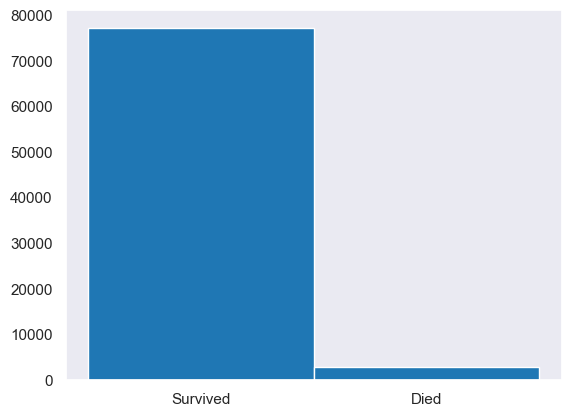

In [13]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

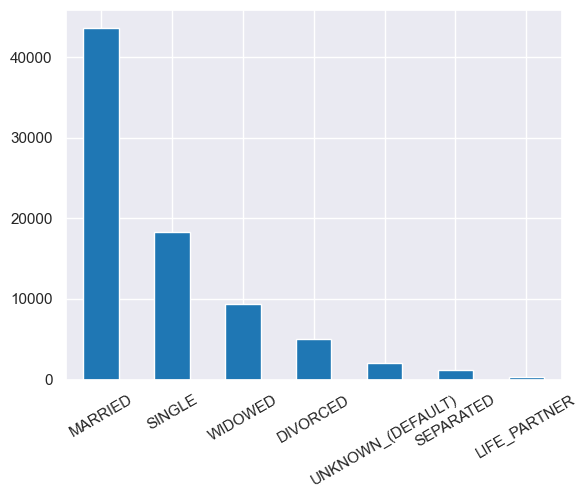

In [14]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

#### Corrélations

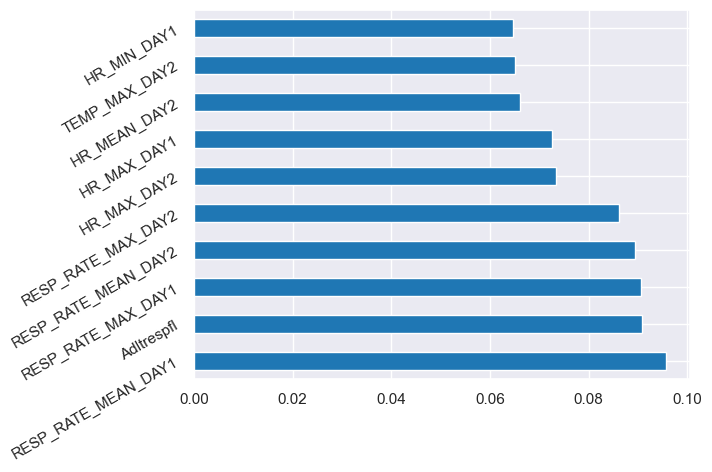

In [15]:
corr = x_df.select_dtypes(exclude=object).corrwith(ys)
top = corr.abs().sort_values(ascending=False).head(10)


top.plot.barh(rot=30)
plt.show()

On remarque que la frequence de respiration moyenne du patient le premier jour de son hospital est la features qui a la plus forte correlation avec la target.

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

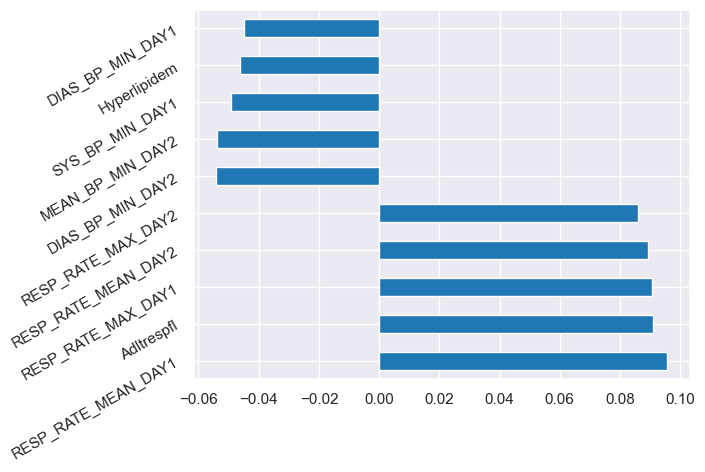

In [16]:
corr = x_df.select_dtypes(exclude=object).corrwith(ys) # On retire les features catégoriques, sinon on obtient des NaN 
toppos = corr[corr>=0].sort_values(ascending=False).head(5)
topneg = corr[corr<0].sort_values(ascending=True).head(5)
top = pd.concat([toppos, topneg])

top.plot.barh(rot=30)
plt.show()

#### Autres graphiques ou résultats d'une analyse exploratoire

In [17]:
is_male = x_df["GENDER"] == "M"
is_female = x_df["GENDER"] == "F"
m_count = is_male.sum()
f_count = is_female.sum()
m_death_rate = ys[is_male].sum() / m_count
f_death_rate = ys[is_female].sum() / f_count
print(f"Male death rate: {m_death_rate * 100 : .3f}%")
print(f"Female death rate: {f_death_rate * 100 : .3f}%")

Male death rate:  3.184%
Female death rate:  3.929%


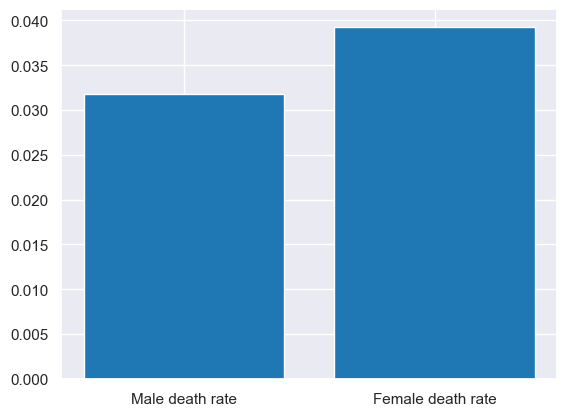

In [18]:
plt.bar([0, 1], [m_death_rate, f_death_rate])
plt.xticks([0, 1], ["Male death rate", "Female death rate"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

On peut s'apercevoir que le pourcentage de survie des femmes est plus bas que celui des hommes.

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [19]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [20]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [21]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [22]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [23]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [24]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [25]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

On décide de ne pas simplifier les données, on a mis le code en commentaire.

In [26]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


#merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
#print(x_test_df["RELIGION"].value_counts())

#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

In [27]:
print(x_test_df["MARITAL_STATUS"].value_counts()/len(x_test_df))
merge_rare_categories([x_df, x_test_df], col="MARITAL_STATUS", keep_n=3)
print(x_test_df["MARITAL_STATUS"].value_counts())

MARRIED               0.543
SINGLE                0.232
WIDOWED                0.12
DIVORCED             0.0608
UNKNOWN_(DEFAULT)    0.0248
SEPARATED             0.015
LIFE_PARTNER        0.00475
Name: MARITAL_STATUS, dtype: float64
Index(['MARRIED', 'SINGLE', 'WIDOWED'], dtype='object')
MARRIED    10856
SINGLE      4635
WIDOWED     2400
OTHER       2110
Name: MARITAL_STATUS, dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [28]:
def label_encode(df, other_df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [29]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,OTHER,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [31]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [32]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [33]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [34]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1h_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1h_df = x_all_1h_df.iloc[: len(x_df)].copy()
x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 337) (20001, 337)
(79999, 474) (20001, 474)


#### Suppression des variables à valeur unique (constantes)

In [35]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [36]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)
x_test_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 301) (20001, 301)


### Création de l'ensemble de validation

On définit une fonction qui permettra de plus simplement préparer les données.

In [37]:
def prepare_xs(xs):
    xs = xs.copy()
    xs.drop(columns=DROP_VARS, inplace=True)
    x_nans = xs.isna().sum()
    x_miss = x_nans[x_nans > 0]
    na_cols = set(x_miss.index)
    for col in na_cols:
        xs[col].fillna(xs[col].mode()[0], inplace=True)
    xs = pd.get_dummies(xs)
    const_cols = {col for col in xs if len(xs[col].unique()) == 1}
    xs.drop(const_cols, axis="columns", inplace=True)
    return xs

def prepare_and_split(xs, ys):
    xs = prepare_xs(xs)
    return model_selection.train_test_split(xs, ys, test_size=0.3)

In [38]:
x_train, x_test, y_train, y_test = prepare_and_split(x_raw_df, ys)

In [39]:
x_train.shape

(55999, 305)

In [40]:
x_test.shape

(24000, 305)

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

In [41]:
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [42]:
pca = decomposition.PCA(n_components = 20)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

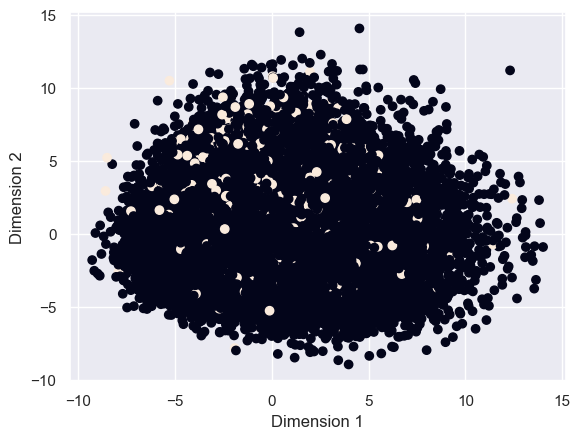

In [43]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

On peut voir que la PCA ne semble pas créer beaucoup de corrélation
Il y a plus de points blancs entre -200 et 200, mais il y a également plus de points noirs dans cette zone, donc il semble vraiment ne pas y avoir de corrélation.

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [44]:
SCORING = "balanced_accuracy"

In [45]:
random_forest = ensemble.RandomForestClassifier(n_estimators=10)
random_forest.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

In [46]:
logistic_regression = linear_model.LogisticRegression()
logistic_regression.fit(x_train, y_train) # training

LogisticRegression()

In [47]:
gaussian = naive_bayes.GaussianNB()
gaussian.fit(x_train, y_train) # training

GaussianNB()

## 6. Évaluations

In [48]:
y_pred = random_forest.predict(x_test)  # predictions
random_forest_score = metrics.balanced_accuracy_score(y_test, y_pred)  # scoring
print(f"Balanced accuracy score: {random_forest_score:.3g}")

Balanced accuracy score: 0.5


In [49]:
gaussian_score = metrics.balanced_accuracy_score(y_test, gaussian.predict(x_test))
print(f"Balanced accuracy score: {gaussian_score:.3g}")

Balanced accuracy score: 0.505


In [50]:
logistic_regression_score = metrics.balanced_accuracy_score(y_test, gaussian.predict(x_test))
print(f"Balanced accuracy score: {logistic_regression_score:.3g}")

Balanced accuracy score: 0.505


### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [51]:
CV = 10

In [52]:
random_forest_scores = model_selection.cross_val_score(random_forest, x_test, y_test, scoring=SCORING, cv=CV)

In [53]:
gaussian_scores = model_selection.cross_val_score(gaussian, x_test, y_test, scoring=SCORING, cv=CV)

In [54]:
logistic_regression_scores = model_selection.cross_val_score(
    logistic_regression, x_test, y_test, scoring=SCORING, cv=CV
)

* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

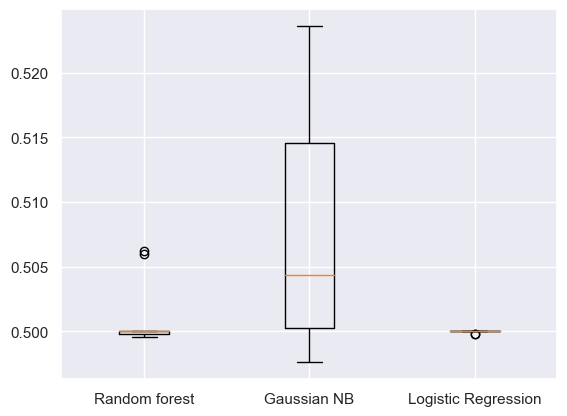

In [55]:
plt.boxplot((random_forest_scores, gaussian_scores, logistic_regression_scores))
plt.xticks([1, 2, 3], ["Random forest", "Gaussian NB", "Logistic Regression"])
plt.show()

On va maintenant essayer plusieurs valeurs de PCA.

In [56]:
x_all = prepare_xs(pd.concat([x_raw_df, x_raw_test_df]))
x_train = x_all.iloc[:len(x_raw_df)].copy()
x_test = x_all.iloc[len(x_raw_df):].copy()

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA(n_components=150)),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", linear_model.LogisticRegression()),
    ]
)

pipe.fit(x_train, ys)
predictions = pipe.predict(x_test)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1h_df, x_test_1h_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")


The submission is ready: Submissions\submission_2023-04-26T23-47-29.zip


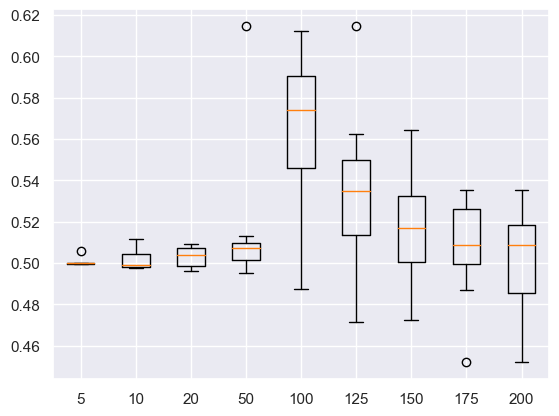

In [57]:
pca_values_to_try = [5, 10, 20, 50, 100, 125, 150, 175, 200]
Model = naive_bayes.GaussianNB

x_train, x_test, y_train, y_test = prepare_and_split(x_raw_df, ys)
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

trained_models = []
scores = []
for pca_n_comp in pca_values_to_try:
    pca = decomposition.PCA(n_components=pca_n_comp)
    x_current_train = pca.fit_transform(x_train)
    x_current_test = pca.transform(x_test)
    current_model_instance = Model()
    current_model_instance.fit(x_current_train, y_train)
    trained_models.append((current_model_instance, x_current_test))
    current_score = model_selection.cross_val_score(current_model_instance, x_current_test, y_test, scoring=SCORING, cv=CV)
    scores.append(current_score)

plt.boxplot(scores)
plt.xticks(range(1, len(pca_values_to_try) + 1), pca_values_to_try)
plt.show()

L'APC semble améliorer la qualité, mais selon le seed, le meilleure nombre de composants pour l'APC varie de 100 à 150.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

In [ ]:
# TODO: Confusion Mtx
model, x_test = trained_models[0]
y_pred = model.predict(x_test) # predictions
score = metrics.roc_auc_score(y_test, y_pred)  # scoring

print(f"ROC accuracy score: {score:.3g}")


ROC accuracy score: 0.5%


In [59]:
from sklearn.model_selection import GridSearchCV

models = {
    # RandomForestClassifier AUC: 0.6871 (best params: {'n_estimators': 250})
    "RandomForestClassifier": {
        "model": ensemble.RandomForestClassifier(),
        "params": {"n_estimators": [10, 20, 50, 100, 150, 200, 250, 300]}
    }
    # Problèmes de crash de Kernel
#    "Decision Tree": {
#        "model": tree.DecisionTreeClassifier(),
#        "params": {
#            "criterion": ["gini", "entropy"],
#            "max_depth": [None, 2, 5, 10],
#            "min_samples_split": [2, 5, 10],
#            "min_samples_leaf": [1, 2, 4],
#        },
#    },
    # K-Nearest Neighbors AUC: 0.6368 (best params: {'n_neighbors': 20, 'weights': 'distance'})
#    "K-Nearest Neighbors": {
#        "model": neighbors.KNeighborsClassifier(),
#        "params": {
#            "n_neighbors": [5, 10, 20],
#            "weights": ["uniform", "distance"],
#        },
#    },
    # Problèmes de crash de Kernel
#    "Support Vector Machine": {
#        "model": svm.SVC(),
#        "params": {
#            "C": [0.1, 1, 10],
#            "kernel": ["linear", "poly", "rbf", "sigmoid"],
#            "gamma": ["scale", "auto"],
#        },
#    },
    # Trop long (>1h)
#    "Gradient Boosting": {
#        "model": ensemble.GradientBoostingClassifier(),
#        "params": {
#            "n_estimators": [10, 50, 100, 200],
#            "learning_rate": [0.01, 0.1, 1],
#            "max_depth": [None, 2, 5, 10],
#            "min_samples_split": [2, 5, 10],
#            "min_samples_leaf": [1, 2, 4],
#        },
#    },
}

# Boucle pour tester chaque modèle avec sa combinaison d'hyperparamètres
for model_name, model_params in models.items():
    # Débug
    print(f"Testing {model_name}...")
    model = model_params["model"]
    params = model_params["params"]
    x_train, x_test, y_train, y_test = prepare_and_split(x_raw_df, ys)
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    pca = decomposition.PCA(n_components=100)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    # Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres pour ce modèle
    grid = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(x_train, y_train)
    
    # Obtenir les prédictions sur le jeu de test avec les meilleurs hyperparamètres trouvés
    y_pred_proba = grid.best_estimator_.predict_proba(x_test)[:, 1]
    
    # Aire sous la courbe ROC (AUC) pour évaluer la performance du modèle
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} AUC: {auc:.4f} (best params: {grid.best_params_})")

Testing RandomForestClassifier...
RandomForestClassifier AUC: 0.6986 (best params: {'n_estimators': 300})


* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

In [60]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)
pipe = pipeline.Pipeline(steps=[
    ("scaler", preprocessing.StandardScaler()),
    ("pca", decomposition.PCA(n_components=125)),
    ("rfc", ensemble.RandomForestClassifier(n_estimators=250))
])
x_train, x_test, y_train, y_test = prepare_and_split(x_raw_df, ys)
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

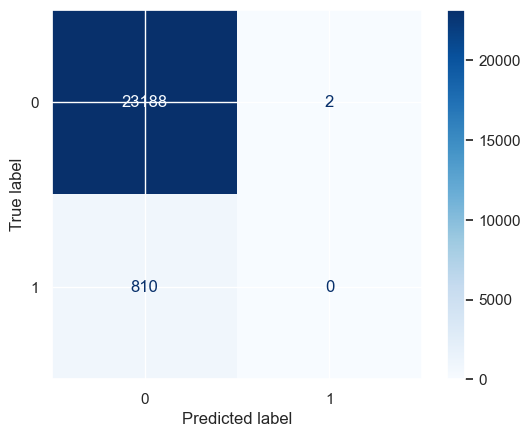

In [61]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap=plt.cm.Blues
)

Sur le test beaucoup de personnes mortes(1) ont été classées comme vivantes(0). Mais aucun prédiction de mort n'a été erronée.

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

Data Augmentation V1 (temps d'entraînement trop long, résultats finaux mauvais)

In [62]:
#pipe = imblearn.pipeline.Pipeline(
#    [
#        ("scale", preprocessing.StandardScaler()),
#        ("pca", decomposition.PCA(n_components=150)),
#        ("resample", imblearn.over_sampling.SMOTE()),
#        ("model", neural_network.MLPClassifier()),
#    ]
#)
#mlp_scores = model_selection.cross_val_score(pipe, prepare_xs(x_raw_df), ys, scoring=SCORING, cv=CV)
#plt.boxplot(mlp_scores)
#plt.show()

Data Augmentation V2

In [63]:
x_all = prepare_xs(pd.concat([x_raw_df, x_raw_test_df]))
x_train = x_all.iloc[:len(x_raw_df)].copy()
x_test = x_all.iloc[len(x_raw_df):].copy()

In [ ]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA(n_components=150)),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", ensemble.RandomForestClassifier(n_estimators=200)),
    ]
)

In [ ]:
scores = model_selection.cross_val_score(pipe, prepare_xs(x_raw_df), ys, scoring="balanced_accuracy", cv=10)
plt.boxplot(scores)
plt.show()

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

• Le suréchantillonnage (oversampling) est une technique pour équilibrer les données dans les cas ou les classes sont desequilibrées. L'echantillonnage permet de résoudre ce déséquilibre en aumgnentant artificiellement la taille des classes minoritaires (par exemple avec l'algorithme SMOTHE qui est un excellent algorithme pour faire cela puisqu'il permet de générer des donnees synthétiques a partir des données de la classe minoritaire : elle utilise les k voisins les plus proches d'un échantillon pour en générer de nouveaux) 
• Dans notre cas, le surechantillonnage est utile car nos classes sont desequilibrees, en effets il y a  beaucoup plus de patient qui restent en vie que de partient qui meurent.
L'echantillonage nous permet donc reequilibrer les deux classes pour reduire les biais.

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1h_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [ ]:
pipe.fit(x_train, ys)
predictions = pipe.predict(x_test)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1h_df, x_test_1h_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---